In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# 작사가 인공지능 만들기

작사가 인공지능을 들어 가기전 가벼운 sentence로 시작해보겠습니다.

In [2]:
from IPython.display import Image

In [3]:
sentence = " 나는 밥을 먹었다 "

source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
print("Target 문장:", target_sentence)

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


- 인공지능이 글을 이해하게 하는 방식은 수많은 글을 읽게 함으로써 나는 , 밥을, 그다음이 먹는다 라는 사실을 알게 하는 겁니다.

- 이 방식을 가장 잘 처리하는 인공지능 중 하나가 순환신경망(RNN) 입니다.

In [4]:
import os, re 
import numpy as np
import tensorflow as tf
import glob
# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
raw_corpus = []
txt_file_path = os .getenv('HOME') + '/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

for txt_file in txt_list: 
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus)) # 187,088
print("Examples:\n", raw_corpus[:10]) # 데이터 확인

데이터 크기: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face [Verse 1]', "Somethin' ain't right when we talkin'"]


셰익스피어의 연극 대본입니다.

여기서 필요한 건 대사(문장)만을 원하므로 화 이름이나 공백뿐인 정보는 필요가 없습니다.

In [5]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

[Hook]
I've been down so long, it look like up to me
They look up to me
I got fake people showin' fake love to me
Straight up to my face, straight up to my face
I've been down so long, it look like up to me
They look up to me
I got fake people showin' fake love to me
Straight up to my face, straight up to my face [Verse 1]
Somethin' ain't right when we talkin'


텍스트 분류 모델에서 많이 보신 것처럼 텍스트 생성 모델에도 단어 사전을 만들게 됩니다. 그렇다면 문장을 일정한 기준으로 쪼개야겠죠? 그 과정을 토큰화(Tokenize) 라고 합니다.

1. Hi, my name is John. *("Hi," "my", ..., "john." 으로 분리됨) - 문장부호

2. First, open the first chapter. *(First와 first를 다른 단어로 인식) - 대소문자

3. He is a ten-year-old boy. *(ten-year-old를 한 단어로 인식) - 특수문자

"1." 을 막기 위해 문장 부호 양쪽에 공백을 추가 할 것이고, "2." 를 막기 위해 모든 문자들을 소문자로 변환 할 겁니다. "3."을 막기 위해 특수문자들은 모두 제거 하도록 해보겠습니다.

In [6]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


- 자연어처리 분야에서 모델의 입력이 되는 문장을 소스 문장(Source Sentence) , 정답 역할을 하게 될 모델의 출력 문장을 타겟 문장(Target Sentence) 라고 관례적으로 부릅니다. 각각 X_train, y_train 에 해당한다고 할 수 있겠습니다.

In [7]:
# # 여기에 정제된 문장을 모을겁니다
# corpus = []

# for sentence in raw_corpus:
#     # 우리가 원하지 않는 문장은 건너뜁니다
#     if len(sentence) == 0: continue
#     if sentence[-1] == ":": continue
    
#     # 정제를 하고 담아주세요
#     preprocessed_sentence = preprocess_sentence(sentence)
#     corpus.append(preprocessed_sentence)
        
# # 정제된 결과를 10개만 확인해보죠
# corpus[:10]

corpus = [] 
for sentence in raw_corpus: # 우리가 원하지 않는 문장은 건너뜁니다 
    if len(sentence) == 0: continue 
    if sentence[-1] == "]": continue 
    if sentence[-1] == ")": continue # 정제를 하고 담아주세요 
    preprocessed_sentence = preprocess_sentence(sentence) 
    if preprocessed_sentence.count(" ") >= 15: continue 
    corpus.append(preprocessed_sentence) # 정제된 결과를 10개만 확인해보죠 corpus[:10]

인공지능이 알아 들을 수 있는 숫자로 변환해서 인공지능에게 넘겨 줄 겁니다.

텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공하는데, 우리도 그 모듈을 십분 활용할 겁니다! 아래에서 활용하게 될 tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환까지 한 방에 해줍니다. 이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 칭합니다. 

In [8]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    4   92 ...   10   12    3]
 [   2   37  134 ...    0    0    0]
 [   2    4   36 ...    0    0    0]
 ...
 [   2   87  694 ...    0    0    0]
 [   2  204    3 ...    0    0    0]
 [   2    9 1525 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fa6eb9d2dd0>


생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해 봅시다

In [9]:
# print(tensor[:3, :10])

- 텐서 데이터는 모두 정수로 이루어져 있습니다. 이 숫자는 다름 아니라, tokenizer에 구축된 단어 사전의 인덱스입니다. 단어 사전이 어떻게 구축되었는지 아래와 같이 확인해 봅시다.

In [10]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [11]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])
print(len(src_input))
print(len(tgt_input))

[  2   4  92 104  58  31 164   5  11 134  23  30  10  12]
[  4  92 104  58  31 164   5  11 134  23  30  10  12   3]
148425
148425


In [12]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1 

# 준비한 데이터 소스로부터 데이터셋을 만듭니다.
# 데이터셋에 대해서는 아래 문서를 참고하세요.
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다.
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

이번 스텝에서 데이터셋을 생성하기 위해 거쳐 온 과정을 잘 기억해 두시길 바랍니다.


- 정규표현식을 이용한 corpus 생성
- tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
- tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환


dataset을 얻음으로써 데이터 다듬기 과정은 끝났습니다. tf.data.Dataset에서 제공하는 shuffle(), batch() 등 다양한 데이터셋 관련 기능을 손쉽게 이용할 수 있게 되었군요.

이 모든 일련의 과정을 텐서플로우에서의 데이터 전처리 라 칭합니다!

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 500
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [14]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.28765096e-04, -1.84473305e-04,  5.69115546e-05, ...,
         -3.94750605e-05, -1.78712828e-04, -4.96433699e-04],
        [-1.16321439e-06, -3.78069992e-04, -1.09919965e-04, ...,
         -1.81048053e-05, -4.00293386e-04, -1.02617254e-03],
        [ 1.63814839e-04, -1.44164878e-04, -4.19155898e-04, ...,
          1.17303345e-04, -6.27521251e-04, -1.08912226e-03],
        ...,
        [-7.49783823e-04,  5.41700749e-04, -2.34041899e-03, ...,
         -1.26219972e-03,  1.55611255e-03,  3.65271862e-03],
        [-7.67096528e-04,  5.91280230e-04, -2.83170724e-03, ...,
         -1.26799720e-03,  1.81144697e-03,  4.04870277e-03],
        [-7.91114580e-04,  6.48870540e-04, -3.30227264e-03, ...,
         -1.25105202e-03,  2.03804090e-03,  4.39728005e-03]],

       [[-1.28765096e-04, -1.84473305e-04,  5.69115546e-05, ...,
         -3.94750605e-05, -1.78712828e-04, -4.96433699e-04],
        [-5.94757264e-04, -3.25595989e-04,  3

In [15]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6000500   
_________________________________________________________________
lstm (LSTM)                  multiple                  6246400   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 32,940,629
Trainable params: 32,940,629
Non-trainable params: 0
_________________________________________________________________


 optimizer와 loss등은 차차 배웁니다
 혹시 미리 알고 싶다면 아래 문서를 참고하세요
 https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
 https://www.tensorflow.org/api_docs/python/tf/keras/losses
 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
sou_train, sou_val, tar_train, tar_val = train_test_split(src_input, tgt_input, test_size=0.2)
sou_val_train1, tar_val_val1, sou_val_train2, tar_val_val2 = train_test_split(sou_train, tar_train, test_size = 0.125 , random_state = 2)
print("Source Train:", sou_train.shape)
print("Target Train:", sou_val_train1.shape)

Source Train: (118740, 14)
Target Train: (103897, 14)


In [18]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
data1 = model.fit(sou_train,tar_train,validation_data = (tar_val_val1, tar_val_val2),batch_size=128, epochs=10)

Epoch 1/10
928/928 [==============================] - 190s 201ms/step - loss: 3.6915 - accuracy: 0.4751 - val_loss: 2.9355 - val_accuracy: 0.5255
Epoch 2/10
928/928 [==============================] - 187s 201ms/step - loss: 2.8982 - accuracy: 0.5294 - val_loss: 2.7044 - val_accuracy: 0.5398
Epoch 3/10
928/928 [==============================] - 186s 200ms/step - loss: 2.6915 - accuracy: 0.5422 - val_loss: 2.5314 - val_accuracy: 0.5531
Epoch 4/10
928/928 [==============================] - 188s 202ms/step - loss: 2.5197 - accuracy: 0.5550 - val_loss: 2.3708 - val_accuracy: 0.5664
Epoch 5/10
928/928 [==============================] - 186s 200ms/step - loss: 2.3674 - accuracy: 0.5685 - val_loss: 2.2213 - val_accuracy: 0.5834
Epoch 6/10
928/928 [==============================] - 228s 246ms/step - loss: 2.2207 - accuracy: 0.5856 - val_loss: 2.0827 - val_accuracy: 0.6015
Epoch 7/10
928/928 [==============================] - 184s 198ms/step - loss: 2.0877 - accuracy: 0.6024 - val_loss: 1.9560 -

glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

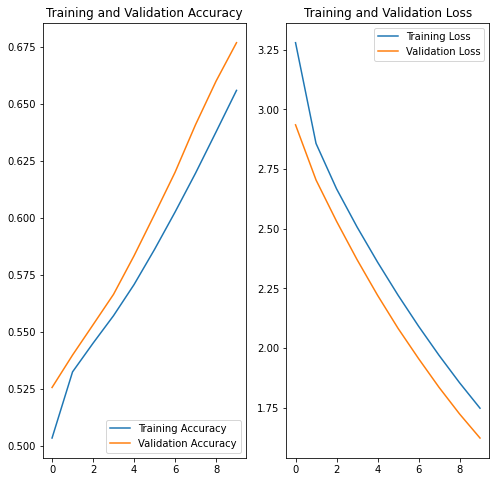

✅


In [20]:

import matplotlib.pyplot as plt

acc = data1.history['accuracy']
val_acc = data1.history['val_accuracy']

loss=data1.history['loss']
val_loss=data1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [23]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [32]:

generate_text(model, tokenizer, init_sentence="<start> sexy", max_len=20)

'<start> sexy motherfucker <end> '

In [50]:
variable = ["i", "love","sexy"]

In [51]:
for i in variable:
    print(generate_text(model, tokenizer, init_sentence=i, max_len=50))

i you know that i m a liar <end> 
love and i ll be waiting <end> 
sexy i m the only one <end> 
